In [4]:
import numpy as np
import mbo_utilities as mbo
import tifffile
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.ndimage import generic_filter

In [5]:
files = [x for x in Path().home().joinpath("temp").iterdir()]
raw = tifffile.imread(files[0])
raw.shape

(448, 224)

In [4]:
results = r"D:\tests_bigmem\roi2\suite2p\anatomical\plane7\F.npy"
f = np.load(results)

In [5]:
f.shape

(276, 5632)

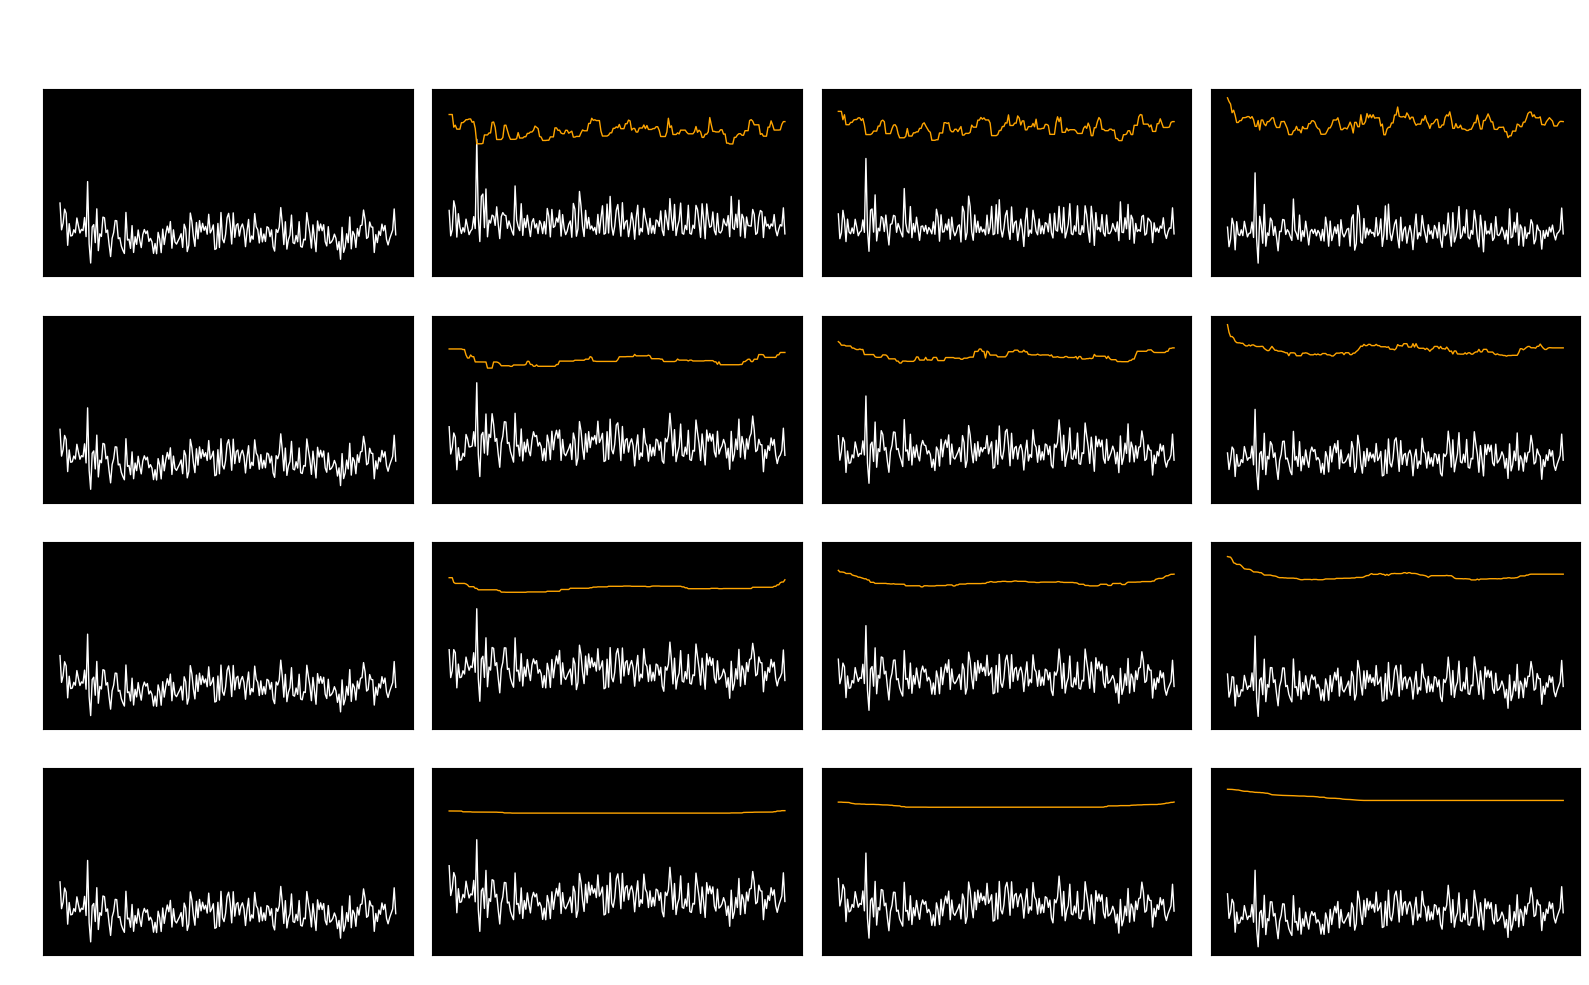

In [24]:

time = np.arange(len(trace))
window_sizes = [5, 17, 60, 300]
percentiles = [8, 20, 40]
baseline_types = ["median"] + percentiles

# Setup figure
fig, axs = plt.subplots(
    len(window_sizes), len(baseline_types),
    figsize=(4 * len(baseline_types), 2.5 * len(window_sizes)),
    sharex=True, sharey=True,
    facecolor='black'
)

for i, win in enumerate(window_sizes):
    for j, base in enumerate(baseline_types):
        if base == "median":
            f0 = np.median(trace)
            dff = ((trace - f0) / f0) * 100
            label = "Median F₀"
        else:
            f0 = generic_filter(trace, lambda x: np.percentile(x, base), size=win, mode='nearest')
            dff = ((trace - f0) / f0) * 100
            label = f"{base}th percentile F₀ (win={win})"
            
        ax = axs[i, j]
        ax.plot(time, dff, color='white', lw=1)
        if not base == "median":
            ax.plot(time, f0, color='orange', lw=1, label='F₀')
        ax.set_facecolor("black")
        ax.set_title(label, color="white", fontsize=10)
        ax.tick_params(colors='white', labelsize=8)

fig.suptitle("ΔF/F Across Baseline Choices and Window Sizes", color="white", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.97])
fig.patch.set_alpha(0)

from pathlib import Path
output_path = Path("./res/fig_comparisons.png")
output_path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(output_path, dpi=300, transparent=True)

In [25]:
def compare_dff_baselines(trace, window_short=20, window_long=100):
    time = np.arange(len(trace))

    # Baseline strategies
    static_median = np.median(trace)
    static_20th = np.percentile(trace, 20)
    moving_20th_short = generic_filter(trace, lambda x: np.percentile(x, 20), size=window_short, mode='nearest')
    moving_20th_long = generic_filter(trace, lambda x: np.percentile(x, 20), size=window_long, mode='nearest')

    # ΔF/F0 (%)
    dff_median = (trace - static_median) / static_median * 100
    dff_20th = (trace - static_20th) / static_20th * 100
    dff_mov_short = (trace - moving_20th_short) / moving_20th_short * 100
    dff_mov_long = (trace - moving_20th_long) / moving_20th_long * 100

    # Plot
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True, facecolor='black')

    axs[0].plot(time, trace, color='white', label="Raw Trace")
    axs[0].hlines(static_median, time[0], time[-1], color="cyan", ls="--", label="Static Median")
    axs[0].hlines(static_20th, time[0], time[-1], color="magenta", ls=":", label="Static 20th %ile")
    axs[0].plot(time, moving_20th_short, color="orange", lw=1, label=f"Moving 20th (win={window_short})")
    axs[0].plot(time, moving_20th_long, color="green", lw=1, label=f"Moving 20th (win={window_long})")
    axs[0].legend()
    axs[0].set_ylabel("Fluorescence")
    axs[0].set_title("Baseline Estimates")
    axs[0].set_facecolor("black")
    axs[0].tick_params(colors='white')

    axs[1].plot(time, dff_median, color="cyan", label="ΔF/F Median")
    axs[1].plot(time, dff_20th, color="magenta", label="ΔF/F 20th %ile")
    axs[1].plot(time, dff_mov_short, color="orange", label=f"ΔF/F Mov{window_short}")
    axs[1].plot(time, dff_mov_long, color="green", label=f"ΔF/F Mov{window_long}")
    axs[1].legend()
    axs[1].set_ylabel("ΔF/F (%)")
    axs[1].set_xlabel("Frame")
    axs[1].set_title("ΔF/F with Different Baselines")
    axs[1].set_facecolor("black")
    axs[1].tick_params(colors='white')

    fig.tight_layout()
    fig.patch.set_alpha(0)
    plt.show()


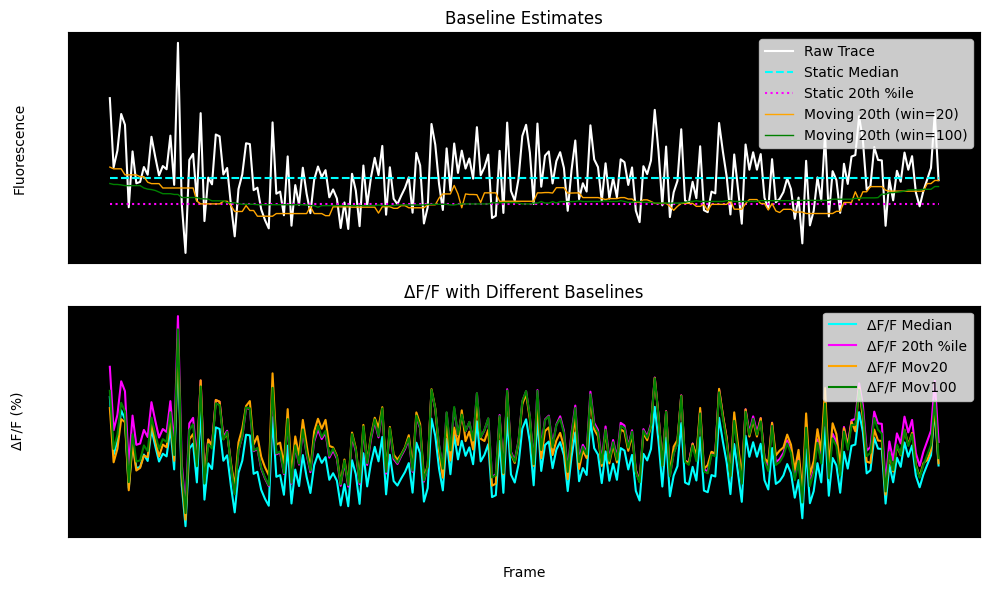

In [27]:
compare_dff_baselines(f[0])

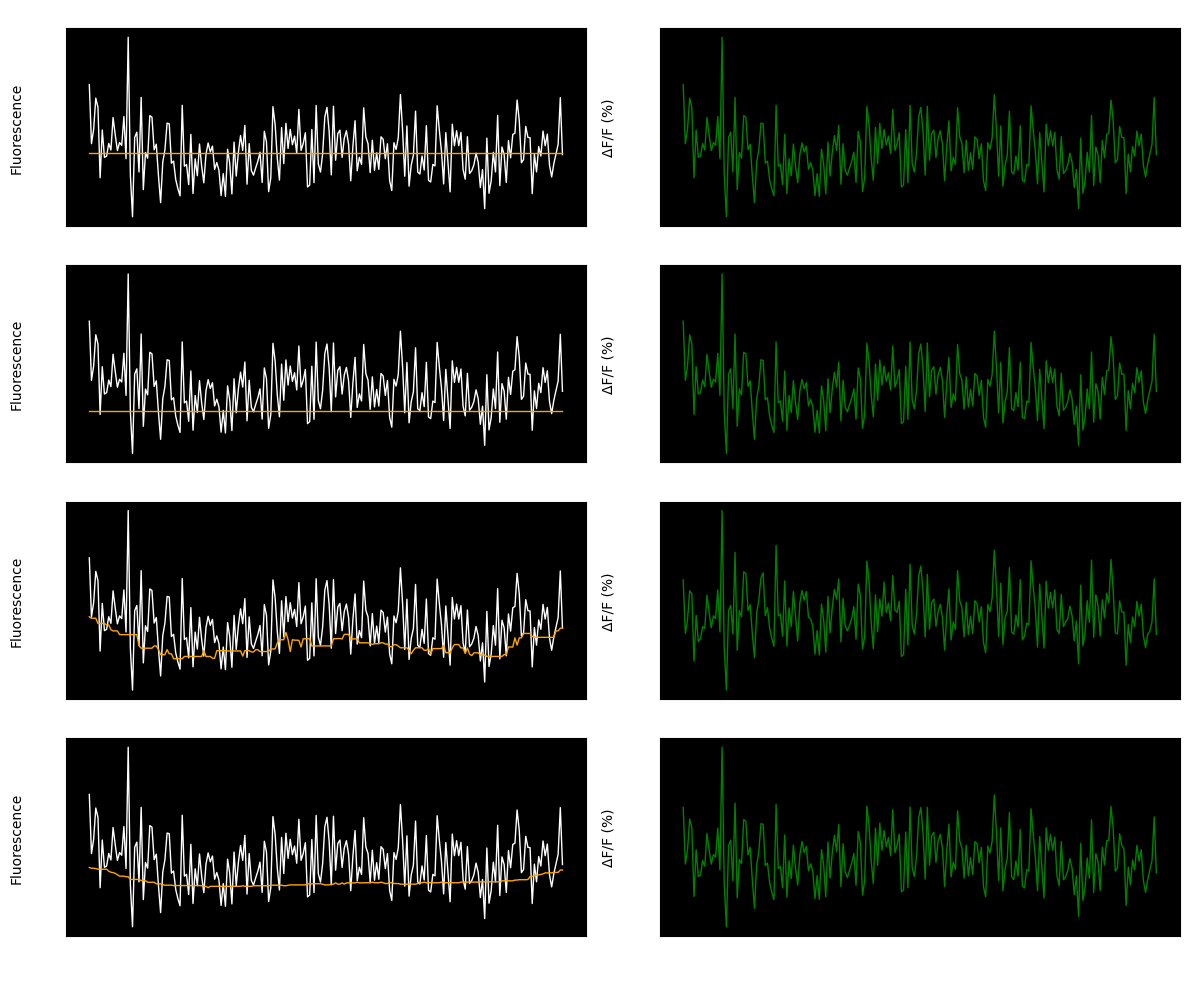

In [30]:
def compare_dff_baseline(trace, window_short=20, window_long=100):
    import matplotlib.pyplot as plt
    plt.close('all')

    time = np.arange(len(trace))

    baselines = {
        "Static Median": np.full_like(trace, np.median(trace)),
        "Static 20th percentile": np.full_like(trace, np.percentile(trace, 20)),
        f"Moving 20th (win={window_short})": generic_filter(trace, lambda x: np.percentile(x, 20), size=window_short, mode='nearest'),
        f"Moving 20th (win={window_long})": generic_filter(trace, lambda x: np.percentile(x, 20), size=window_long, mode='nearest'),
    }

    fig, axs = plt.subplots(len(baselines), 2, figsize=(12, 2.5 * len(baselines)), sharex=True, facecolor='black')

    for i, (label, f0) in enumerate(baselines.items()):
        dff = (trace - f0) / f0 * 100

        axs[i, 0].plot(time, trace, color='white', lw=1)
        axs[i, 0].plot(time, f0, color='orange', lw=1)
        axs[i, 0].set_ylabel("Fluorescence")
        axs[i, 0].set_title(f"{label} - Raw + F₀", color='white', fontsize=10)
        axs[i, 0].set_facecolor("black")
        axs[i, 0].tick_params(colors='white')

        axs[i, 1].plot(time, dff, color='green', lw=1)
        axs[i, 1].set_ylabel("ΔF/F (%)")
        axs[i, 1].set_title(f"{label} - ΔF/F", color='white', fontsize=10)
        axs[i, 1].set_facecolor("black")
        axs[i, 1].tick_params(colors='white')

    axs[-1, 0].set_xlabel("Frame", color='white')
    axs[-1, 1].set_xlabel("Frame", color='white')
    fig.tight_layout()
    fig.patch.set_alpha(0)
    plt.show()

compare_dff_baseline(f[0])

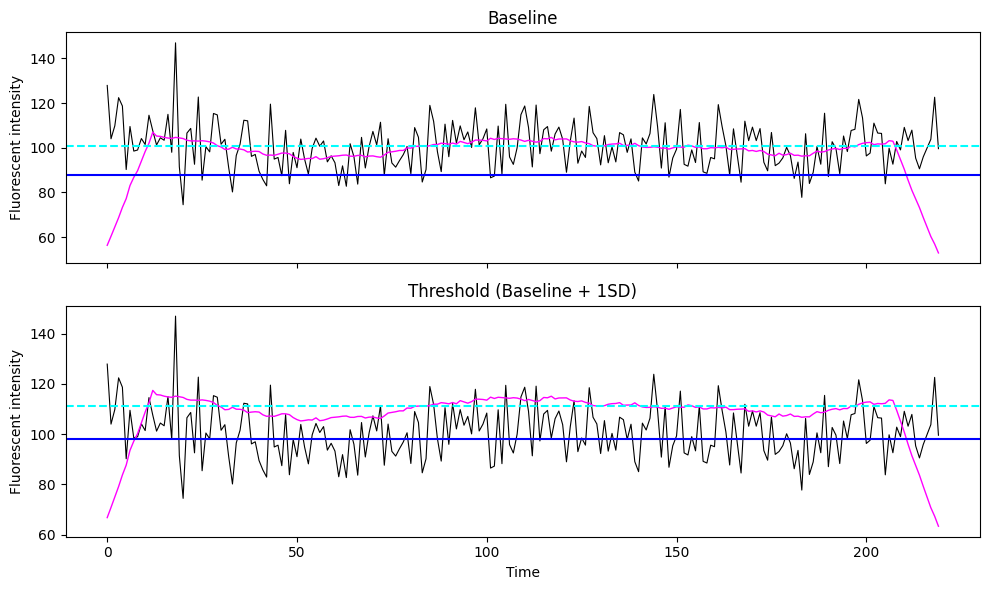

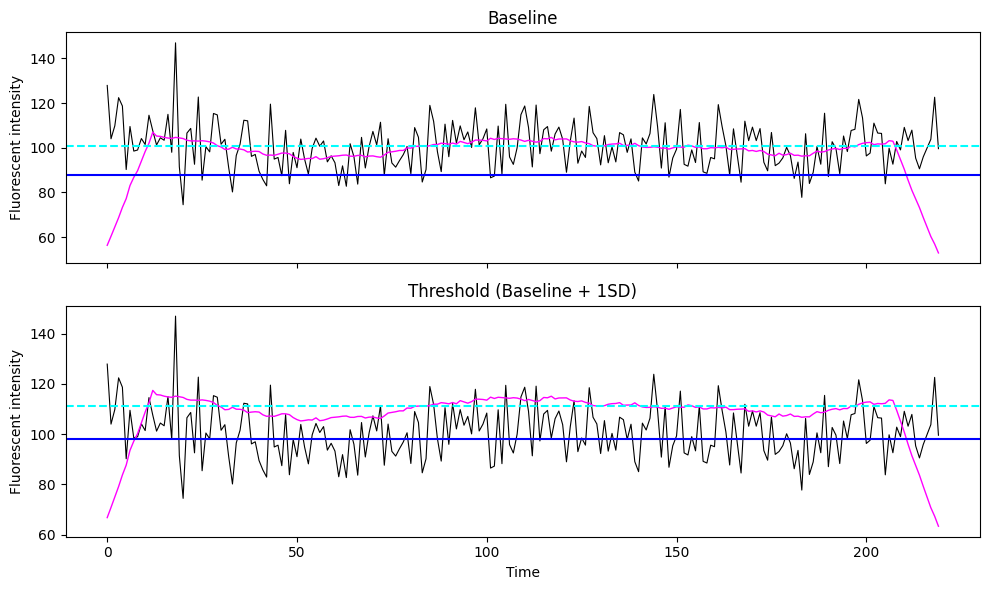

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def plot_baseline_threshold(f, window=25, save_path=None):
    """
    Plot raw trace, moving average, baseline (10th percentile), and threshold (baseline + 1SD).
    
    Parameters
    ----------
    f : array-like
        Fluorescence trace (1D).
    window : int
        Window size for moving average.
    save_path : str or Path, optional
        Path to save the figure. If None, the figure is not saved.
    """
    f = np.asarray(f)
    mov_mean = np.convolve(f, np.ones(window)/window, mode='same')
    
    baseline = np.percentile(f, 10)
    mean = np.mean(f)
    std = np.std(f)

    mean_plus_1sd = mean + std
    baseline_plus_1sd = baseline + std
    mov_mean_plus_1sd = mov_mean + std

    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    axs[0].plot(f, color='black', linewidth=0.8)
    axs[0].plot(mov_mean, color='magenta', linewidth=1)
    axs[0].axhline(mean, color='cyan', linestyle='--')
    axs[0].axhline(baseline, color='blue')
    axs[0].set_title("Baseline")
    axs[0].set_ylabel("Fluorescent intensity")

    axs[1].plot(f, color='black', linewidth=0.8)
    axs[1].plot(mov_mean_plus_1sd, color='magenta', linewidth=1)
    axs[1].axhline(mean_plus_1sd, color='cyan', linestyle='--')
    axs[1].axhline(baseline_plus_1sd, color='blue')
    axs[1].set_title("Threshold (Baseline + 1SD)")
    axs[1].set_ylabel("Fluorescent intensity")
    axs[1].set_xlabel("Time")

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    return fig
    
plot_baseline_threshold(f[0])